<a href="https://colab.research.google.com/github/danielmonroym/ProyectoFinalIA/blob/main/PROYECTO_FASE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lo primero es configurar el Notebook con todas las librerías necesarias para la lectura, limpieza y análisis de los datos.


In [2]:
from __future__ import print_function, division
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import check_random_state
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
warnings.filterwarnings('ignore')
rs = check_random_state(4421)

In [3]:
data = pd.read_csv("./games.csv")

data

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,t1_champ2id,t1_champ2_sum1,t1_champ2_sum2,t1_champ3id,t1_champ3_sum1,t1_champ3_sum2,t1_champ4id,t1_champ4_sum1,t1_champ4_sum2,t1_champ5id,t1_champ5_sum1,t1_champ5_sum2,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t1_ban1,t1_ban2,t1_ban3,t1_ban4,t1_ban5,t2_champ1id,t2_champ1_sum1,t2_champ1_sum2,t2_champ2id,t2_champ2_sum1,t2_champ2_sum2,t2_champ3id,t2_champ3_sum1,t2_champ3_sum2,t2_champ4id,t2_champ4_sum1,t2_champ4_sum2,t2_champ5id,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,2,8,12,4,432,3,4,96,4,7,11,11,6,112,4,14,11,1,2,3,0,92,40,69,119,141,104,11,4,498,4,7,122,6,4,238,14,4,412,4,3,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,1,119,7,4,39,12,4,76,4,3,10,4,14,35,4,11,10,4,0,2,1,51,122,17,498,19,54,4,12,25,4,14,120,11,4,157,4,14,92,4,7,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,0,18,4,7,141,11,4,267,3,4,68,4,12,38,12,4,8,1,1,1,0,117,40,29,16,53,69,4,7,412,14,4,126,4,12,24,4,11,22,7,4,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,0,57,4,12,63,4,14,29,4,7,61,4,1,36,11,4,9,2,1,2,0,238,67,516,114,31,90,14,4,19,11,4,412,4,3,92,4,14,22,4,7,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,0,19,4,12,29,11,4,40,4,3,119,4,7,134,7,4,9,2,1,3,0,90,64,412,25,31,37,3,4,59,4,12,141,11,4,38,4,12,51,4,7,3,0,0,1,0,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,3308904636,1503076540231,1944,9,2,1,2,2,0,2,0,19,12,4,429,4,7,91,4,14,432,4,14,64,4,11,2,0,0,0,0,114,18,11,157,497,45,12,4,83,12,4,67,4,7,40,3,4,79,11,4,10,2,0,4,0,55,-1,90,238,157
51486,3215685759,1496957179355,3304,9,2,1,1,2,2,2,2,90,4,14,32,4,11,31,12,4,412,14,4,18,4,7,5,4,0,2,0,157,164,122,99,420,102,11,4,429,7,4,89,3,4,75,4,12,45,14,4,11,7,4,4,1,157,55,119,154,105
51487,3322765040,1504029863961,2156,9,2,2,2,2,0,1,0,141,11,4,18,7,4,432,3,4,81,12,4,68,4,12,0,0,0,1,0,238,31,24,53,11,1,4,12,119,7,4,33,11,4,43,12,4,99,14,4,10,2,0,2,0,113,122,53,11,157
51488,3256675373,1499562036246,1475,9,2,2,2,2,0,2,0,121,11,4,236,4,7,420,4,12,201,4,3,99,4,14,0,0,0,0,0,119,64,51,157,29,21,7,4,56,4,12,25,4,14,30,12,4,11,11,4,11,3,0,1,0,154,39,51,90,114


Limpieza de Datos

In [4]:
data.head(10)

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,t1_champ2id,t1_champ2_sum1,t1_champ2_sum2,t1_champ3id,t1_champ3_sum1,t1_champ3_sum2,t1_champ4id,t1_champ4_sum1,t1_champ4_sum2,t1_champ5id,t1_champ5_sum1,t1_champ5_sum2,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t1_ban1,t1_ban2,t1_ban3,t1_ban4,t1_ban5,t2_champ1id,t2_champ1_sum1,t2_champ1_sum2,t2_champ2id,t2_champ2_sum1,t2_champ2_sum2,t2_champ3id,t2_champ3_sum1,t2_champ3_sum2,t2_champ4id,t2_champ4_sum1,t2_champ4_sum2,t2_champ5id,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,2,8,12,4,432,3,4,96,4,7,11,11,6,112,4,14,11,1,2,3,0,92,40,69,119,141,104,11,4,498,4,7,122,6,4,238,14,4,412,4,3,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,1,119,7,4,39,12,4,76,4,3,10,4,14,35,4,11,10,4,0,2,1,51,122,17,498,19,54,4,12,25,4,14,120,11,4,157,4,14,92,4,7,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,0,18,4,7,141,11,4,267,3,4,68,4,12,38,12,4,8,1,1,1,0,117,40,29,16,53,69,4,7,412,14,4,126,4,12,24,4,11,22,7,4,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,0,57,4,12,63,4,14,29,4,7,61,4,1,36,11,4,9,2,1,2,0,238,67,516,114,31,90,14,4,19,11,4,412,4,3,92,4,14,22,4,7,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,0,19,4,12,29,11,4,40,4,3,119,4,7,134,7,4,9,2,1,3,0,90,64,412,25,31,37,3,4,59,4,12,141,11,4,38,4,12,51,4,7,3,0,0,1,0,86,11,201,122,18
5,3287435705,1501667992132,2059,9,1,2,2,1,1,2,0,40,3,4,141,11,4,24,12,4,45,3,4,67,4,7,8,1,1,1,0,117,6,238,122,105,92,4,12,15,4,7,245,12,4,2,4,11,12,4,14,6,0,0,3,0,119,134,154,63,31
6,3314215542,1503430065724,1993,9,1,1,2,1,1,1,1,74,3,4,17,4,12,412,3,4,18,4,7,57,4,11,10,2,1,2,1,157,11,141,32,35,53,4,14,21,4,7,114,12,4,161,21,4,19,11,4,2,0,0,0,0,75,42,31,40,429
7,3329224025,1504472363684,1334,9,1,1,1,0,0,2,1,150,12,4,498,7,4,16,4,3,90,4,14,79,11,4,6,0,0,0,1,117,19,157,29,18,112,4,7,64,11,4,497,14,4,67,4,7,57,4,12,0,0,0,2,0,157,38,122,40,238
8,3318040883,1503686577549,1387,9,2,2,2,2,0,2,2,111,12,4,57,4,11,18,7,4,267,4,3,161,3,4,0,0,0,0,0,154,117,31,126,157,29,7,4,59,4,12,99,21,4,141,4,11,63,14,4,8,1,0,2,1,28,51,53,157,40
9,3327786881,1504385918871,2681,9,2,2,2,2,2,2,0,427,4,3,11,11,4,75,12,4,429,7,4,131,4,14,10,1,0,2,0,31,238,141,17,119,35,4,11,110,4,7,74,4,14,99,3,4,86,12,4,8,3,1,2,0,64,141,84,67,53


In [ ]:
data.dtypes

gameId          int64
creationTime    int64
gameDuration    int64
seasonId        int64
winner          int64
                ...  
t2_ban1         int64
t2_ban2         int64
t2_ban3         int64
t2_ban4         int64
t2_ban5         int64
Length: 61, dtype: object

Se puede observar que todos los datos del dataset son números, lo que implica que no es necesario realizar algún trabajo de conversión de tipos y los modelos generados se desempeñaran mejor.

In [ ]:
data.isnull().sum()

gameId          0
creationTime    0
gameDuration    0
seasonId        0
winner          0
               ..
t2_ban1         0
t2_ban2         0
t2_ban3         0
t2_ban4         0
t2_ban5         0
Length: 61, dtype: int64

No se encontraron valores nulos o NaN en todo el dataset por lo que se puede continuar con el uso de este.

Ahora se eligen las variables con las que se va a trabajar en los modelos. Cada fila de la tabla contiene los datos del equipo que ha ganado una partida y del equipo que ha perdido una partida.

Se ha decidido separar en dos dataset los datos para poder tener los datos de cada equipo por separado:
 partidas_Equipo1 y partidas_Equipo2. Esto implica que, para que los datos sigan teniendo sentido se deben realizar algunas conversiones y explicaciones.
 
Antes, la variable winner tenía valor 1 o 2 para indicar si el ganador era el equipo 1 o el 2 por lo que ahora que hay dos dataset se cambia por 1 o 0 para indicar si el equipo del respectivo dataset ganó o perdió.

Para firstBlood, firstTower, firstInhibitor, firstDragon, firstRiftHerald se cambia el siginificado de los valores:

- Para "0" si nadie lo ha realizado la primera vez
- Para "1" si lo realizó el equipo del respectivo dataset
- Para "2" si lo realizó el otro equipo


In [5]:
partidas_Equipo1 = data[['gameDuration','firstBlood','firstTower','firstInhibitor','firstBaron','firstDragon','firstRiftHerald','t1_towerKills','t1_inhibitorKills','t1_baronKills','t1_dragonKills','t1_riftHeraldKills','winner']]
partidas_Equipo2 = data[['gameDuration','firstBlood','firstTower','firstInhibitor','firstBaron','firstDragon','firstRiftHerald','t2_towerKills','t2_inhibitorKills','t2_baronKills','t2_dragonKills','t2_riftHeraldKills','winner']]
partidas_Equipo1['winner'] = partidas_Equipo1['winner'].replace({2: 0}, regex=True)
partidas_Equipo2['winner'] = partidas_Equipo2['winner'].replace({1: 0}, regex=True)
partidas_Equipo2['winner'] = partidas_Equipo2['winner'].replace({2: 1}, regex=True)

partidas_Equipo2['firstBlood'] = partidas_Equipo2['firstBlood'].replace({2: 3}, regex=True)
partidas_Equipo2['firstBlood'] = partidas_Equipo2['firstBlood'].replace({1: 2}, regex=True)
partidas_Equipo2['firstBlood'] = partidas_Equipo2['firstBlood'].replace({3: 1}, regex=True)

partidas_Equipo2['firstTower'] = partidas_Equipo2['firstTower'].replace({2: 3}, regex=True)
partidas_Equipo2['firstTower'] = partidas_Equipo2['firstTower'].replace({1: 2}, regex=True)
partidas_Equipo2['firstTower'] = partidas_Equipo2['firstTower'].replace({3: 1}, regex=True)

partidas_Equipo2['firstInhibitor'] = partidas_Equipo2['firstInhibitor'].replace({2: 3}, regex=True)
partidas_Equipo2['firstInhibitor'] = partidas_Equipo2['firstInhibitor'].replace({1: 2}, regex=True)
partidas_Equipo2['firstInhibitor'] = partidas_Equipo2['firstInhibitor'].replace({3: 1}, regex=True)

partidas_Equipo2['firstBaron'] = partidas_Equipo2['firstBaron'].replace({2: 3}, regex=True)
partidas_Equipo2['firstBaron'] = partidas_Equipo2['firstBaron'].replace({1: 2}, regex=True)
partidas_Equipo2['firstBaron'] = partidas_Equipo2['firstBaron'].replace({3: 1}, regex=True)

partidas_Equipo2['firstDragon'] = partidas_Equipo2['firstDragon'].replace({2: 3}, regex=True)
partidas_Equipo2['firstDragon'] = partidas_Equipo2['firstDragon'].replace({1: 2}, regex=True)
partidas_Equipo2['firstDragon'] = partidas_Equipo2['firstDragon'].replace({3: 1}, regex=True)

partidas_Equipo2['firstRiftHerald'] = partidas_Equipo2['firstRiftHerald'].replace({2: 3}, regex=True)
partidas_Equipo2['firstRiftHerald'] = partidas_Equipo2['firstRiftHerald'].replace({1: 2}, regex=True)
partidas_Equipo2['firstRiftHerald'] = partidas_Equipo2['firstRiftHerald'].replace({3: 1}, regex=True)

In [6]:
#Se renombran las variables para poder unir los dos dataset uno debajo del otro,.
partidas_Equipo1.columns = ['gameDuration','firstBlood','firstTower','firstInhibitor','firstBaron','firstDragon','firstRiftHerald','towerKills' ,'inhibitorKills','baronKills','dragonKills','riftHeraldKills','winner']
partidas_Equipo2.columns = ['gameDuration','firstBlood','firstTower','firstInhibitor','firstBaron','firstDragon','firstRiftHerald','towerKills' ,'inhibitorKills','baronKills','dragonKills','riftHeraldKills','winner']
partidas= pd.concat([partidas_Equipo1,partidas_Equipo2],axis=0)
# Se convierte la duración de la partida de segundos a minutos
partidas.index = pd.RangeIndex(len(partidas.index))
partidas['gameDuration'] = (partidas.gameDuration/60).astype(int)

Análisis datos

Text(0.5, 1.0, 'Duración de las partidas')

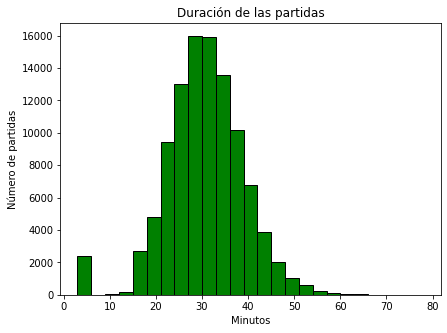

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(partidas["gameDuration"],bins =25,color = "green",edgecolor='black',linewidth=1)
plt.xlabel('Minutos')
plt.ylabel('Número de partidas')
plt.title('Duración de las partidas')


En la grafica de "gameDuration"  se puede observar que muchas de las partidas duran entre 25 y 35 minutos.

In [8]:
partidas["gameDuration"].describe()

count    102980.000000
mean         30.057798
std           8.521393
min           3.000000
25%          25.000000
50%          30.000000
75%          35.000000
max          78.000000
Name: gameDuration, dtype: float64

 Por lo que se decidió cambiar 'gameDuration' por 3 valores que serán más significativos: "1" si la partida dura menos de 25 minutos (Partida que prpobablemente un equipo fue muy superior al otro), "2" si la duración de la partida se encuentra entre los minutos 25 y 35 (Partida normal) y "3" en otro caso (Partida larga).

In [9]:
partidas['gameDuration'] = np.where(partidas['gameDuration']<25,1,np.where(((partidas['gameDuration']>24)&(partidas['gameDuration']<36)),2,3))

In [10]:
partidas

,gameDuration,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,riftHeraldKills,winner
0,2,2,1,1,1,1,2,11,1,2,3,0,1
1,2,1,1,1,0,1,1,10,4,0,2,1,1
2,1,2,1,1,1,2,0,8,1,1,1,0,1
3,2,1,1,1,1,1,0,9,2,1,2,0,1
4,2,2,1,1,1,1,0,9,2,1,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102975,2,1,2,2,0,2,0,10,2,0,4,0,2
102976,3,1,1,2,2,2,2,11,7,4,4,1,2
102977,2,2,2,2,0,1,0,10,2,0,2,0,2
102978,1,2,2,2,0,2,0,11,3,0,1,0,2


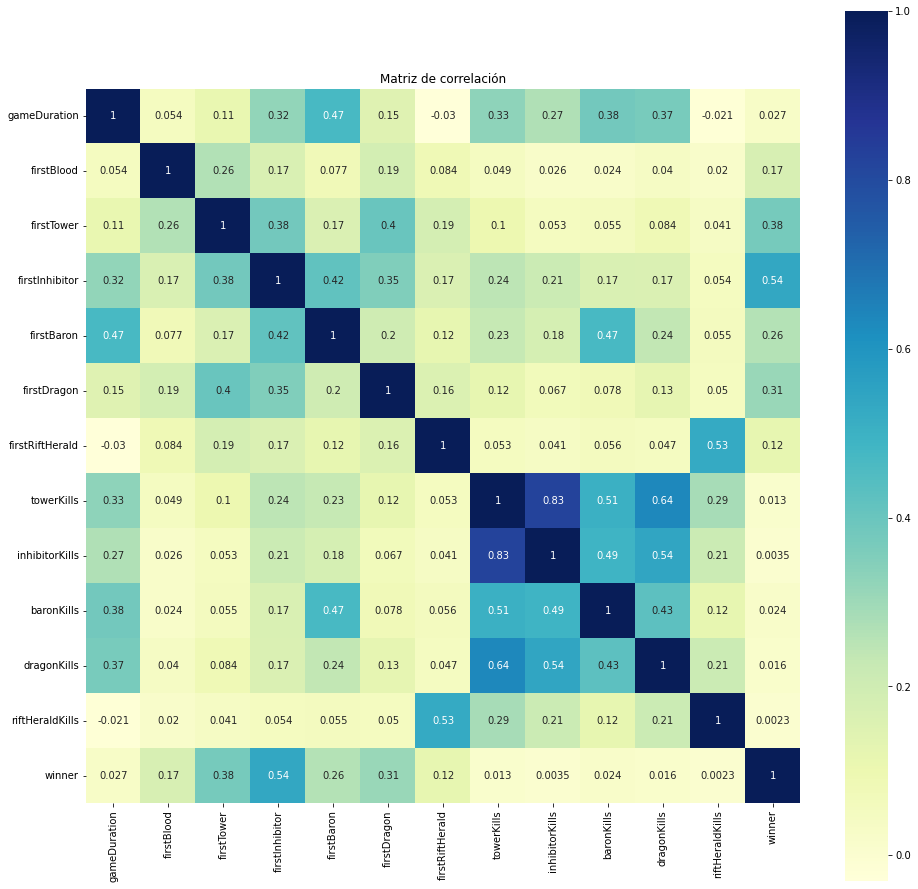

In [11]:
plt.figure(figsize=(16, 16))
plt.title('Matriz de correlación')
sns.heatmap(partidas.corr(), square=True, annot=True,cmap="YlGnBu")

En la matriz de correlación se puede observa que, sorpresivamente variables como firstBaron y firstDragon, que son uno de los objetivos más codiciados del juego no tienen una relación tan fuerte con la variable winner, mientras que variables como firstTower y firstInhibitor influyen más para decidir el ganador de una partida.

Predicciones

Nuestra variable a predecir o Y es la variable winner, 0 si el equipo que se recibe como entrada pierde o 1 si el quipo gana. (Clasificación)

In [12]:
X = partidas.drop(['winner'], axis=1)
Y = partidas['winner']

In [13]:
X

,gameDuration,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,riftHeraldKills
0,2,2,1,1,1,1,2,11,1,2,3,0
1,2,1,1,1,0,1,1,10,4,0,2,1
2,1,2,1,1,1,2,0,8,1,1,1,0
3,2,1,1,1,1,1,0,9,2,1,2,0
4,2,2,1,1,1,1,0,9,2,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
102975,2,1,2,2,0,2,0,10,2,0,4,0
102976,3,1,1,2,2,2,2,11,7,4,4,1
102977,2,2,2,2,0,1,0,10,2,0,2,0
102978,1,2,2,2,0,2,0,11,3,0,1,0


In [14]:
Y

0         1
1         1
2         1
3         1
4         1
         ..
102975    2
102976    2
102977    2
102978    2
102979    1
Name: winner, Length: 102980, dtype: int64

In [16]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.25, random_state=rs)

Encontrar los mejores hiperparámetros para DOS algoritmos predictivos

Para encontrar dos de  los mejores hiperparámetros para DOS algoritmos predictivos se toma un rango de números y se itera entre estos buscando cúal fue la combinación que arrojo la mejor predicción.

También se decide realizar las Matrices de confusión para cada algoritmo



Árbol de decisión

In [82]:
r1 = range(2,40)
r2 = range(1,5)
score = 0
precisiones = []

for estimadores in r1:
    for estimadores2 in r2:
        dt = DecisionTreeRegressor(random_state = rs,min_samples_split = estimadores,min_samples_leaf=estimadores2)
        dt.fit(Xtrain,Ytrain)
        prediccion = dt.predict(Xtest)
        accuracy_test = accuracy_score(Ytest,prediccion.round())
        if (score < accuracy_test):
            Y_pred = prediccion
            score = accuracy_test
            pos1= estimadores
            pos2= estimadores2
        precisiones.insert(estimadores,accuracy_test)
print("precisión de predicción: {0: .3f}".format(score))
print("min_samples_split: " +format(pos1))
print("min_samples_leaf: " +format(pos2))

precisión de predicción:  0.930
min_samples_split: 21
min_samples_leaf: 1


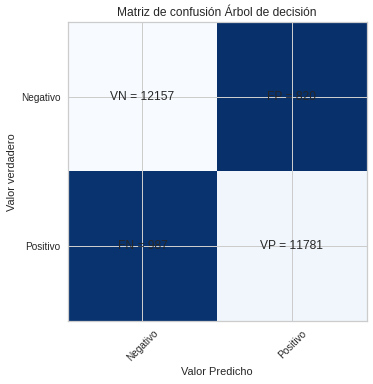

In [85]:
Y_pred = Y_pred.round()
confusion = confusion_matrix(Ytest, Y_pred)
plt.clf()
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues_r)
classNames = ['Negativo','Positivo']
plt.title('Matriz de confusión Árbol de decisión')
plt.ylabel('Valor verdadero')
plt.xlabel('Valor Predicho')

tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['VN','FP'], ['FN', 'VP']]
s = [['VN','FP'], ['FN', 'VP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+" = "+str(confusion[i][j]), horizontalalignment='center', verticalalignment='center')
plt.show()

En la matriz de confusión podemos observar:

- Predijo más de 12000 veces que el equipo iba a perder la partida
- Predijo más de 11000 veces que el equipo iba a ganar la partida
- Predijo alrededor de 900 veces que el equipo iba a perder la partida y realmente la ha ganado
- Predijo  alrededor de 800 veces que el equipo iba a ganar la partida y realmente la ha perdido

Clasificador KNeighbors

In [87]:
rango = range(1,30)
score = 0
precisiones = []
for vecinos in rango:
    knn = KNeighborsClassifier(n_neighbors = vecinos)
    knn.fit(Xtrain,Ytrain)
    if (score < knn.score(Xtest,Ytest)):
        Y_pred = knn.predict(Xtest)
        score = knn.score(Xtest,Ytest)
        pos = vecinos
    precisiones.insert(vecinos,knn.score(Xtest,Ytest))
print("precisión de predicción: {0: .3f}".format(score))
print("n_neighbors: "+format(vecinos))

precisión de predicción:  0.933
n_neighbors: 29


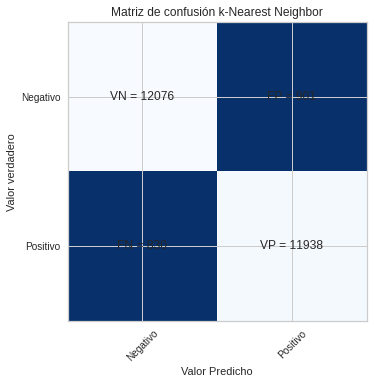

In [88]:
confusion = confusion_matrix(Ytest, Y_pred)
plt.clf()
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues_r)
classNames = ['Negativo','Positivo']
plt.title('Matriz de confusión k-Nearest Neighbor')
plt.ylabel('Valor verdadero')
plt.xlabel('Valor Predicho')

tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['VN','FP'], ['FN', 'VP']]
s = [['VN','FP'], ['FN', 'VP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+" = "+str(confusion[i][j]), horizontalalignment='center', verticalalignment='center')
plt.show()

En la matriz de confusión podemos observar:

- Predijo más de 12000 veces que el equipo iba a perder la partida
- Predijo más de 11000 veces que el equipo iba a ganar la partida
- Predijo alrededor de 800 veces que el equipo iba a perder la partida y realmente la ha ganado
- Predijo  alrededor de 900 veces que el equipo iba a ganar la partida y realmente la ha perdido

Encontrar los mejores hiperparámetros para DOS combinaciones de algoritmo no supervisado + algoritmo predictivo

Para este punto  no se encontró una combinación de algoritmos no
supervisado + algoritmo predictivo por lo que se decidió reemplazarlo por otros dos algoritmos supervisados.

Para encontrar dos de los mejores hiperparámetros para DOS algoritmos predictivos se toma un rango de números y se itera entre estos buscando cúal fue la combinación que arrojo la mejor predicción.

Random Forest

In [89]:
rango = range(1,20)
score = 0
precisiones = []
for estimadores in rango:
    clf = RandomForestClassifier(n_estimators=estimadores, random_state=rs)
    clf.fit(Xtrain,Ytrain)
    prediccion = clf.predict(Xtest)
    accuracy_test = accuracy_score(Ytest,prediccion.round())
    if (score < accuracy_test):
        Y_pred = prediccion
        score = accuracy_test
        pos = estimadores
    precisiones.insert(estimadores,accuracy_test)
print("precisión de predicción: {0: .3f}".format(score))
print("n_estimators: " +format(pos))

precisión de predicción:  0.933
n_estimators: 18


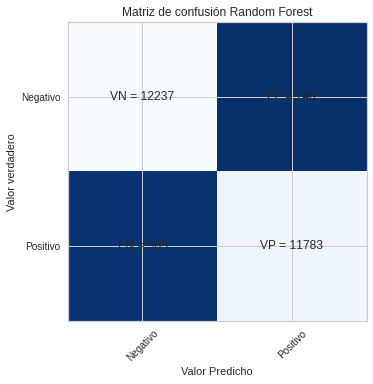

In [90]:
confusion = confusion_matrix(Ytest, Y_pred)
plt.clf()
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues_r)
classNames = ['Negativo','Positivo']
plt.title('Matriz de confusión Random Forest')
plt.ylabel('Valor verdadero')
plt.xlabel('Valor Predicho')

tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['VN','FP'], ['FN', 'VP']]
s = [['VN','FP'], ['FN', 'VP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+" = "+str(confusion[i][j]), horizontalalignment='center', verticalalignment='center')
plt.show()

En la matriz de confusión podemos observar:

- Predijo más de 12000 veces que el equipo iba a perder la partida
- Predijo más de 11000 veces que el equipo iba a ganar la partida
- Predijo alrededor de 900 veces que el equipo iba a perder la partida y realmente la ha ganado
- Predijo  alrededor de 700 veces que el equipo iba a ganar la partida y realmente la ha perdido

Gradient Boosting

In [91]:
rango = range(1,20)
score = 0
precisiones = []
for estimadores in rango:
    gbr = GradientBoostingRegressor(n_estimators = estimadores,max_depth=7,min_samples_split=3,min_samples_leaf=2,max_features=2,random_state=rs)
    gbr.fit(Xtrain,Ytrain)
    prediccion = gbr.predict(Xtest)
    accuracy_test = accuracy_score(Ytest,prediccion.round())
    if (score < accuracy_test):
        Y_pred = prediccion
        score = accuracy_test
        pos = estimadores
    precisiones.insert(estimadores,accuracy_test)
print("precisión de predicción: {0: .3f}".format(score))
print("n_estimators: " +format(pos))

precisión de predicción:  0.918
n_estimators: 18


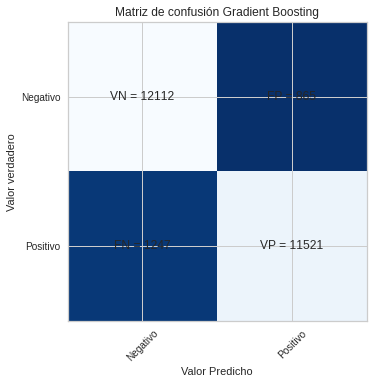

In [92]:
confusion = confusion_matrix(Ytest, Y_pred.round())
plt.clf()
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues_r)
classNames = ['Negativo','Positivo']
plt.title('Matriz de confusión Gradient Boosting')
plt.ylabel('Valor verdadero')
plt.xlabel('Valor Predicho')

tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['VN','FP'], ['FN', 'VP']]
s = [['VN','FP'], ['FN', 'VP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+" = "+str(confusion[i][j]), horizontalalignment='center', verticalalignment='center')
plt.show()

En la matriz de confusión podemos observar:

- Predijo más de 12000 veces que el equipo iba a perder la partida
- Predijo más de 11000 veces que el equipo iba a ganar la partida
- Predijo alrededor de 1200 veces que el equipo iba a perder la partida y realmente la ha ganado
- Predijo  alrededor de 800 veces que el equipo iba a ganar la partida y realmente la ha perdido

Se puede observar que las matrices de confusión de todos los algoritmos arrojan resultados similares.

Realizar las curvas de aprendizaje para cada uno de los cuatro casos anteriores

In [28]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import learning_curve

Se crea una función que "pinte" las curvas de aprendizaje de cada algoritmo, esta función recibe como parametro el estimador, X y Y de entrenamiento y el titulo del algoritmo a "pintar"

In [42]:

def plot_curve(estimator,Xtrain,Ytrain, title):
 train_sizes, train_scores, test_scores  =learning_curve(estimator, Xtrain, Ytrain, 
                                n_jobs=-1,cv=4,
                                  train_sizes=np.linspace(0.1, 1, 10), verbose=0)

 train_scores_mean = np.mean(train_scores, axis=1)
 train_scores_std = np.std(train_scores, axis=1)
 test_scores_mean = np.mean(test_scores, axis=1)
 test_scores_std = np.std(test_scores, axis=1)


 plt.figure()
 plt.title(title)
 plt.legend(loc="best")
 plt.xlabel("Training examples")
 plt.ylabel("Score")
 plt.gca().invert_yaxis()
    
 # box-like grid
 plt.grid()
    
 # plot the std deviation as a transparent range at each training set size
 plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
 plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
 # plot the average training and test score lines at each training set size
 plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
 plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
 # sizes the window for readability and displays the plot
 # shows error from 0 to 1.1
 plt.ylim(-.1,1.1)
 plt.show()

In [ ]:
X

,gameDuration,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,riftHeraldKills
0,2,2,1,1,1,1,2,11,1,2,3,0
1,2,1,1,1,0,1,1,10,4,0,2,1
2,1,2,1,1,1,2,0,8,1,1,1,0
3,2,1,1,1,1,1,0,9,2,1,2,0
4,2,2,1,1,1,1,0,9,2,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
102975,2,1,2,2,0,2,0,10,2,0,4,0
102976,3,1,1,2,2,2,2,11,7,4,4,1
102977,2,2,2,2,0,1,0,10,2,0,2,0
102978,1,2,2,2,0,2,0,11,3,0,1,0


No handles with labels found to put in legend.


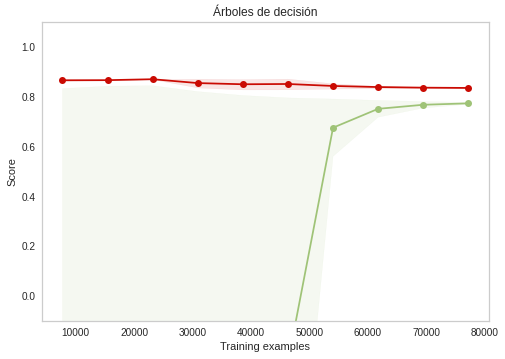

In [49]:
plot_curve(dt,X,Y, "Árboles de decisión")

No handles with labels found to put in legend.


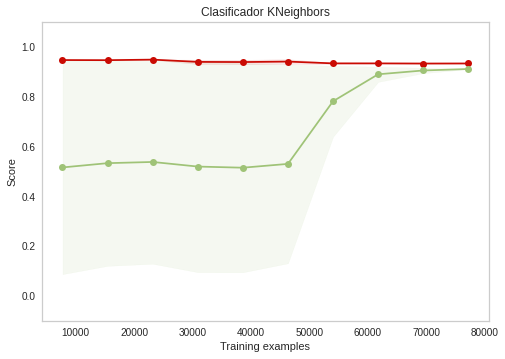

In [52]:
plot_curve(knn,X,Y, "Clasificador KNeighbors") 

No handles with labels found to put in legend.


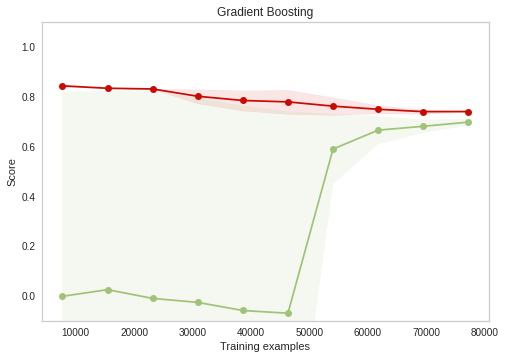

In [50]:
plot_curve(gbr,X,Y, "Gradient Boosting") 

No handles with labels found to put in legend.


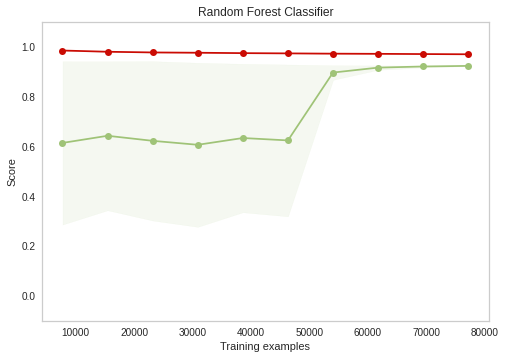

In [51]:
plot_curve(clf,X,Y,"Random Forest Classifier")

Evaluación Diagnóstica:

En las curvas de apredizaje de todos los algoritmos se pudo observar que, Para cada uno de ellos no se presentó un caso de overfitting o bias. Se pudo observar en estas curvas que entre menos datos tuviese el modelo, peor se desmpeñaba cada alogirtmo, a excepción de KNeighbors y Random Forest que siempre presentaron un score por encima del 0.6. Pero cuando a el modelo se le insertaban bastantes más datos se pudo observar una mejor drastica del modelo con el "Training Score" y el "Cross validation score" llegando casi a juntarse.



Ya que se pudo observar que el modelo mejora notablemente con más datos, si se deseara mejorar el desempeño lo mejor sería obtener más datos y mirar cómo se sigue comportando.

También se podría realizar el entrenamiento con otros números para el rango de repeticiones de cada algoritmo y observa si el desempeño mejora.

Se evalua la posibilidad de que, para sacar el modelo a producción se deba tener un error menor al 7% que. Los problemas o retos que este modelo tendría serían principalmente que los datos que se presentan en el Data Set son de hace 4 años, lo que implica que el juego al día de hoy (2021) ha estado en constante cambio y evolución, y los objetivos y condiciones que ayudaban a un equipo de League of Legends a llevarse la victoria pueden haber cambiado drasticamente, por lo que el modelo podría encontrar dificultades para desenvolverse con datos más actualizados.